Epoch 1/10


c:\Users\Predator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


205/205 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.9421 - loss: 0.2442 - val_accuracy: 0.9250 - val_loss: 0.1955
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.9537 - loss: 0.1314 - val_accuracy: 0.9250 - val_loss: 0.1928
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step - accuracy: 0.9704 - loss: 0.0867 - val_accuracy: 0.9311 - val_loss: 0.3032
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.9825 - loss: 0.0466 - val_accuracy: 0.9256 - val_loss: 0.4043
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 0.9920 - loss: 0.0265 - val_accuracy: 0.9256 - val_loss: 0.4539
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.9927 - loss: 0.0216 - val_accuracy: 0.9201 - val_loss: 0.4212
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 25s 122ms/step - accuracy: 0.9950 - loss: 0.0146 - val_accuracy: 0.9195 - val_loss: 0.5773
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - accuracy: 0.9952 - loss: 0.0169 - val

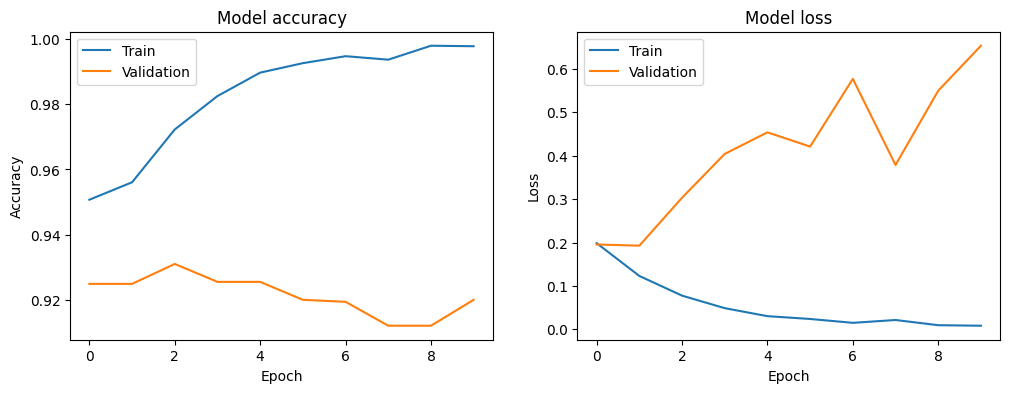

In [10]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
# Define directories for each dataset
directories = {
    'agoda_hotel_reviews': (1, 10),  
    'tripadvisor_hotel_reviews': (1, 5),
    'klook_hotel_reviews': (1, 5),  
    'booking_hotel_reviews': (1, 10)
}

# Function to load and normalize data
def load_and_normalize_data():
    all_reviews = []
    for directory, (min_score, max_score) in directories.items():
        path = os.path.join('raw data', directory)
        for filename in os.listdir(path):
            if filename.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, filename))
                df['normalized_score'] = (df['Review Score'] - min_score) / (max_score - min_score)
                all_reviews.append(df)
    return pd.concat(all_reviews, ignore_index=True)

# Load and normalize data
df = load_and_normalize_data()

# Convert normalized scores to binary labels (1 for positive, 0 for negative)
df['label'] = df['normalized_score'].apply(lambda x: 1 if x >= 0.5 else 0)

# Data Cleaning and Preparation
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Review Content'])
sequences = tokenizer.texts_to_sequences(df['Review Content'])
padded_sequences = pad_sequences(sequences, maxlen=100)

# Splitting data into training and test sets
split_index = int(0.8 * len(padded_sequences))
X_train, X_test = padded_sequences[:split_index], padded_sequences[split_index:]
y_train, y_test = np.array(df['label'][:split_index]), np.array(df['label'][split_index:])

# Model Creation
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
])

# Model Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()




In [ ]:
# Save the model
model.save('sentiment_model.h5')

# Load the trained model for testing
model = load_model('sentiment_model.h5')

def preprocess_review(review, tokenizer, max_len=100):
    # Tokenize the review
    sequence = tokenizer.texts_to_sequences([review])
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    return padded_sequence

def predict_sentiment(review, model, tokenizer):
    # Preprocess the review
    processed_review = preprocess_review(review, tokenizer)
    # Predict the sentiment
    prediction = model.predict(processed_review)
    # Return the prediction score
    return prediction[0][0]

# Example usage
review = "The hotel was fantastic with excellent service"
score = predict_sentiment(review, model, tokenizer)
print(f'Sentiment score: {score}')